In [1]:
import subprocess
import re
import pandas as pd
import sqlite3
import time

In [2]:
import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html

In [3]:
db_filename = "../../../sqlite/ping_data.sqlite"

In [4]:
def bash_command(command):
    p = subprocess.Popen(f'{command}', shell=True, stdout=subprocess.PIPE)
    ret = p.communicate()
    return p.returncode,f'{ret[0].decode("utf-8")}'

In [5]:
def ping(host):
    ping_ret = bash_command(f'ping -c 1 {host}')
    if ping_ret[0] == 0:
        return re.search( "(?<=time=).*?(?= ms)", ping_ret[1].split('\n')[1] ).group(0)
    else:
        return 999

In [122]:
try:
    cur.execute('DROP TABLE ping_data')
    con.commit()
except:
    pass

In [129]:
rawquery="CREATE TABLE ping_data(date TIMESTAMP DEFAULT CURRENT_TIMESTAMP, \
                                'resp_time' REAL, \
                                'host' TEXT);"
cur.execute(rawquery)
con.commit()

In [6]:
def log_ping_data():
    for host in hosts:
        con = sqlite3.connect(db_filename)
        cur = con.cursor()
        rawquery=f"INSERT INTO ping_data(resp_time,host) VALUES ({ping(host)},'{host}');"
        cur.execute(rawquery)
        con.commit()
        con.close()

In [7]:
def req_ping_data(host):
    con = sqlite3.connect(db_filename)
    cur = con.cursor()
    rawquery=f"SELECT resp_time,date FROM (SELECT * FROM ping_data WHERE host = '{host}' ORDER BY date DESC LIMIT 100) ORDER BY date ASC;"
    cur.execute(rawquery)
    colnames = [desc[0] for desc in cur.description]
    df=pd.DataFrame(cur.fetchall(), columns=colnames )
    con.close()
    return df

In [8]:
def cont_log_ping_data():
    while True:
        time.sleep(2)
        log_ping_data()

In [9]:
hosts = ['8.8.8.8','www.youtube.com','84.2.44.1']

In [11]:
app = dash.Dash('Ping monitoring')

app.layout = html.Div([
    dcc.Dropdown(id='my-dropdown',
        options=[
            {'label': '8.8.8.8', 'value': '8.8.8.8'},
            {'label': 'www.youtube.com', 'value': 'www.youtube.com'},
                ],  value='8.8.8.8'),
    dcc.Interval(id='interval-component',  
                 interval=2*1000,  # Milliseconds  
                 n_intervals=0),
    dcc.Graph(id='my-graph')
                        ], style={'width': '500'})

@app.callback(Output('my-graph', 'figure'),
              [Input('my-dropdown', 'value'),
               Input('interval-component','n_intervals')])
def update_graph(selected_dropdown_value,interval):
    df = req_ping_data(selected_dropdown_value)
    return {
        'data': [{
            'x': df.index,
            'y': df.resp_time
        }],
        'layout': {'margin': {'l': 40, 'r': 0, 't': 20, 'b': 30}}
    }

In [12]:
def start_dash():
    app.css.append_css({'external_url': 'https://codepen.io/chriddyp/pen/bWLwgP.css'})
    app.run_server(port=8666)

In [13]:
from multiprocessing import Process

In [14]:
procs = []
proc = Process(target=cont_log_ping_data)
procs.append(proc)
proc.start()
proc = Process(target=start_dash)
procs.append(proc)
proc.start()

 * Serving Flask app "Ping monitoring" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8666/ (Press CTRL+C to quit)
127.0.0.1 - - [20/Feb/2019 15:41:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Feb/2019 15:41:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Feb/2019 15:41:38] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Feb/2019 15:41:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Feb/2019 15:41:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Feb/2019 15:41:41] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Feb/2019 15:41:42] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Feb/2019 15:41:44] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Feb/2019 15:41:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Feb/2019 15:41:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Feb/2019 15:41:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [20/Feb/2019 

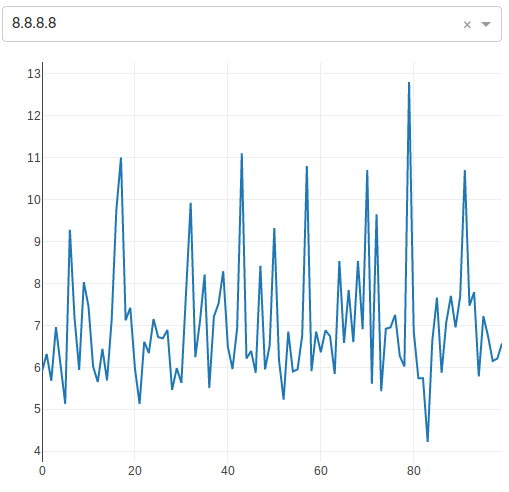

In [15]:
from IPython.display import Image
Image("dash_sc.png")